feasibility to exploit electrons in 2mu2e signal samples

In [1]:
import coffea.processor as processor
from coffea import hist
from coffea.analysis_objects import JaggedCandidateArray

import numpy as np
np.seterr(divide='ignore', invalid='ignore', over='ignore')
import matplotlib.pyplot as plt

In [2]:
import json

dataset2mu2e_ = json.load(open('../Samples/signal_2mu2e.json'))
dataset = dataset2mu2e_

In [3]:
class ElectronProcessor(processor.ProcessorABC):
    def __init__(self):
        dataset_axis = hist.Cat('dataset', 'dataset')
        nelec_axis = hist.Bin('nelec', 'electron multiplicity', 6, 0, 6)
        
        self._accumulator = processor.dict_accumulator({
            "nelec": hist.Hist("#counts/bin", dataset_axis, nelec_axis),
        })
        
    @property
    def accumulator(self):
        return self._accumulator
    
    def process(self, df):
        output = self.accumulator.identity()
        dataset = df['dataset']
        
        electrons = JaggedCandidateArray.candidatesfromcounts(
            df['electron_p4'],
            px=df['electron_p4.fCoordinates.fX'],
            py=df['electron_p4.fCoordinates.fY'],
            pz=df['electron_p4.fCoordinates.fZ'],
            energy=df['electron_p4.fCoordinates.fT'],
        )
        
        output['nelec'].fill(dataset=dataset, nelec=electrons.counts)
        
        return output
    
    def postprocess(self, accumulator):
        return accumulator

In [4]:
output = processor.run_uproot_job(dataset,
                                  treename="ffNtuplizer/ffNtuple",
                                  processor_instance=ElectronProcessor(),
                                  executor=processor.futures_executor,
                                  executor_args=dict(workers=12, flatten=True),
                                  chunksize=500000,
                                 )

Processing: 100%|██████████| 156/156 [00:09<00:00, 17.26items/s]


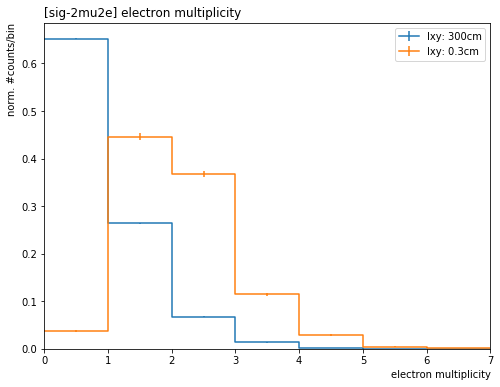

In [5]:
fig, ax = plt.subplots(figsize=(8,6))
_, _, prim0 = hist.plot1d(output['nelec']['*lxy-300'].project('dataset'), ax=ax, overflow='over', density=True)
_, _, prim1 = hist.plot1d(output['nelec']['*lxy-0p3'].project('dataset'), ax=ax, overflow='over', density=True, clear=False)

handles = [tuple(prim0[None]), tuple(prim1[None])]
labels = ['lxy: 300cm', 'lxy: 0.3cm']
ax.legend(handles, labels)
ax.set_title('[sig-2mu2e] electron multiplicity', x=0.0, ha="left")
ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
ax.set_ylabel('norm. '+ax.get_ylabel(), y=1.0, ha="right");